=== Resultados para Quantum = 2 ===
Tempo Médio de Espera: 82.60
Tempo Médio de Retorno: 94.90
Vazão: 0.06

=== Resultados para Quantum = 4 ===
Tempo Médio de Espera: 67.50
Tempo Médio de Retorno: 79.80
Vazão: 0.07

=== Resultados para Quantum = 6 ===
Tempo Médio de Espera: 63.40
Tempo Médio de Retorno: 75.70
Vazão: 0.07



C:\Users\ronal\AppData\Local\Temp\ipykernel_11016\3605409522.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=quanta, y=avg_waiting, palette="Blues_d")
C:\Users\ronal\AppData\Local\Temp\ipykernel_11016\3605409522.py:151: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=quanta, y=avg_return, palette="Greens_d")
C:\Users\ronal\AppData\Local\Temp\ipykernel_11016\3605409522.py:159: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=quanta, y=throughput, palette="Oranges_d")


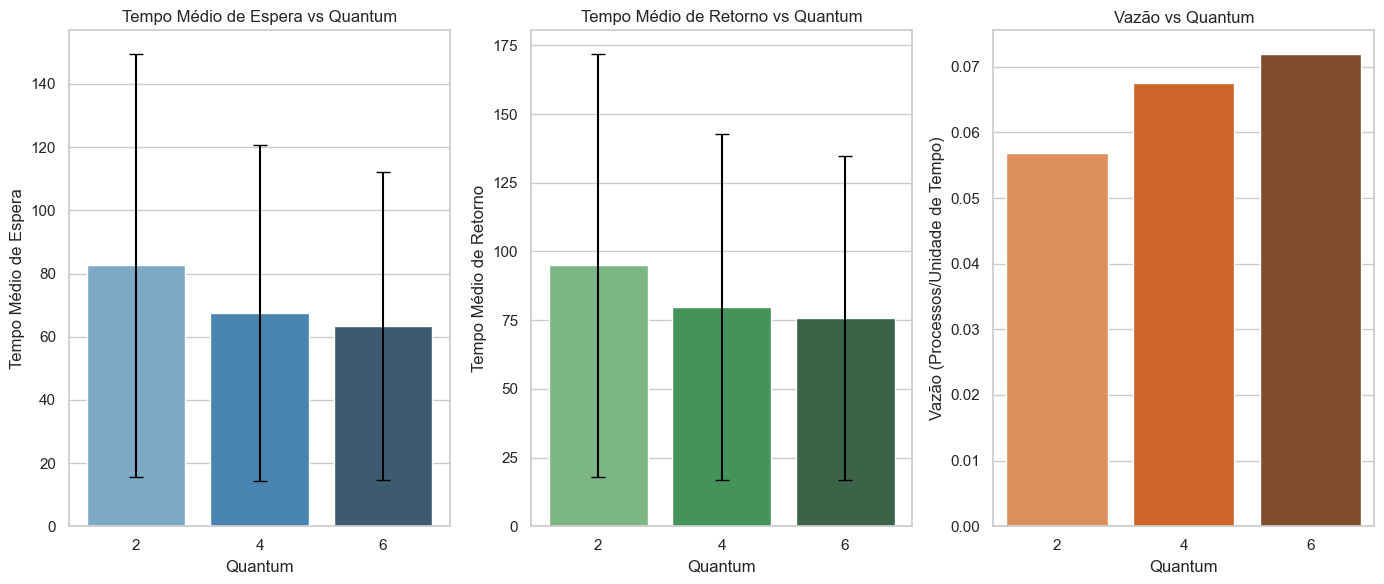

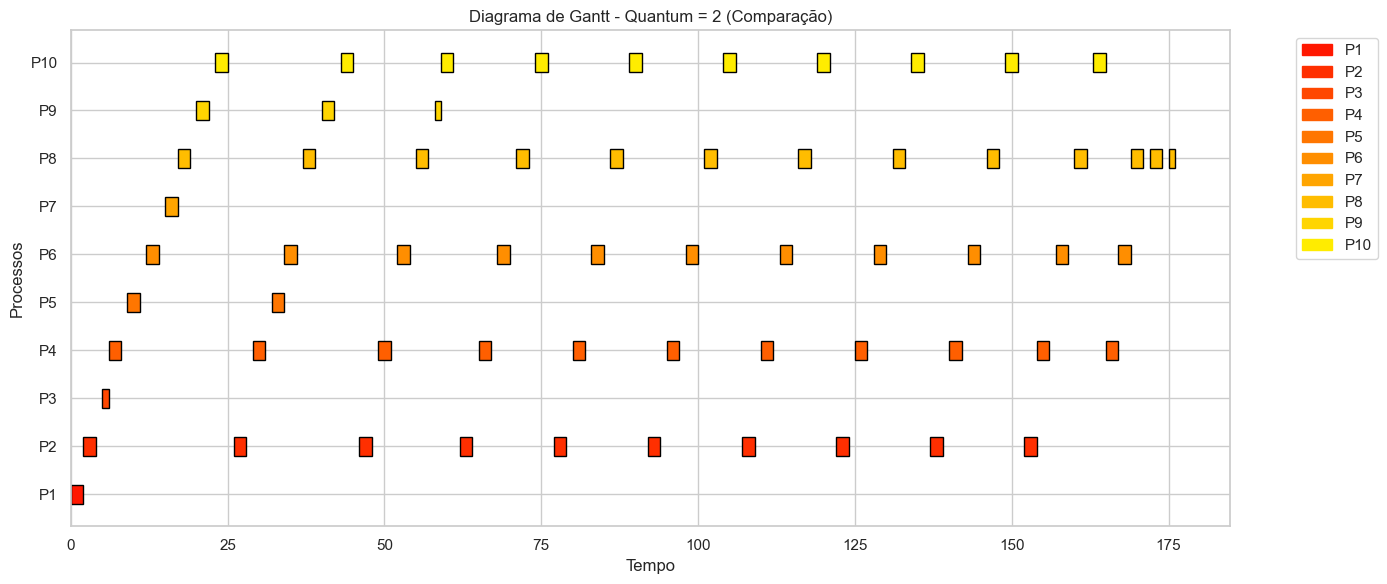

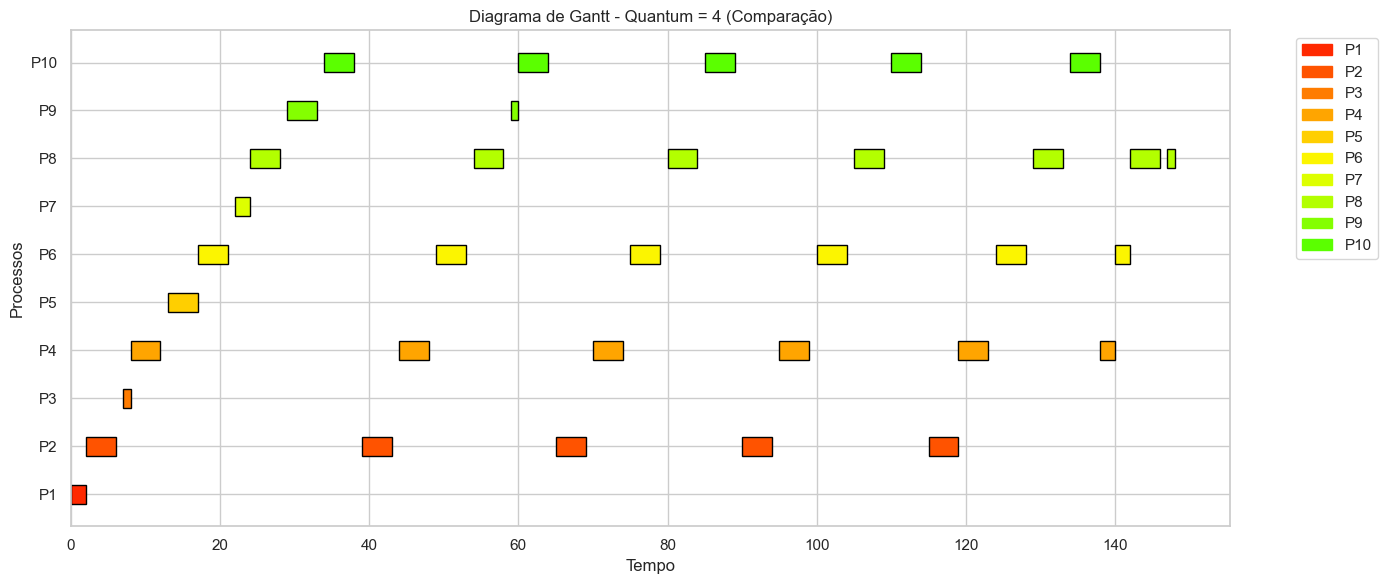

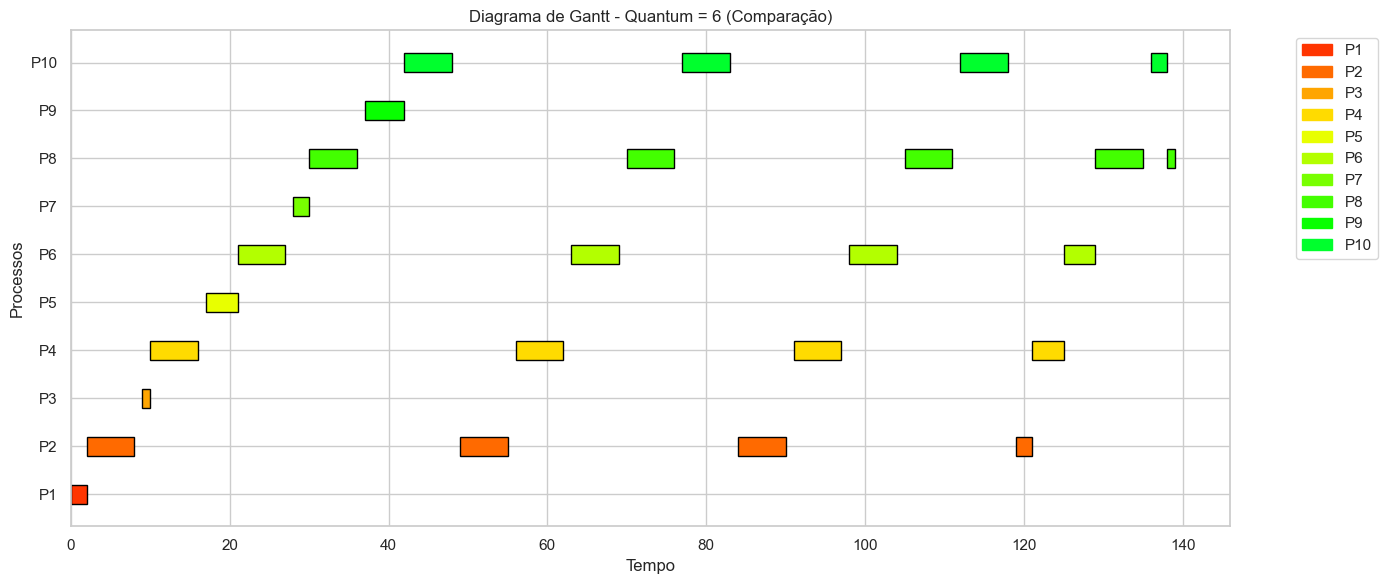

Simulação concluída! 🎉 Aproveite os gráficos e métricas! 😄


In [1]:
from collections import deque
import random
import copy
import statistics
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Estilo para os gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


# Classe Process - representa cada processo do sistema
class Process:
    def __init__(self, name, burst_time):
        self.name = name
        self.burst_time = burst_time
        self.remaining_time = burst_time
        self.initial_time = None        # Quando o processo começou a ser executado pela primeira vez
        self.completion_time = None     # Quando o processo terminou completamente

    def reset(self):
        # Caso precise re-simular, este método retorna o processo ao estado inicial
        self.remaining_time = self.burst_time
        self.initial_time = None
        self.completion_time = None


def round_robin(processes, quantum, arrival_time=0):
    """
    Função que simula o escalonamento Round Robin.
    - processes: lista de processos (objetos da classe Process)
    - quantum: valor do quantum (tempo de fatia de CPU para cada processo)
    - arrival_time: tempo de chegada dos processos (aqui assumimos todos chegam em 0)

    Retorna um dicionário com diversas métricas e a sequência de execução.
    """
    ready_queue = deque(processes)
    current_time = 0
    finished_processes = 0
    total_processes = len(processes)

    execution_sequence = []  # Armazena (tempo_inicio, nome_processo, duração_executada)
    waiting_time_list = []
    return_time_list = []

    # Loop até que todos os processos sejam concluídos
    while finished_processes < total_processes:
        if not ready_queue:
            # Se não há processo pronto, avança o tempo
            current_time += 1
            continue

        # Pega o próximo processo da fila
        process = ready_queue.popleft()

        # Se for a primeira execução do processo, registra o tempo inicial
        if process.initial_time is None:
            process.initial_time = current_time

        # Determina o tempo de execução do processo neste "turno"
        exec_time = min(quantum, process.remaining_time)
        process.remaining_time -= exec_time

        # Adiciona a execução no histórico
        execution_sequence.append((current_time, process.name, exec_time))

        # Avança o tempo corrente
        current_time += exec_time

        # Verifica se o processo finalizou
        if process.remaining_time == 0:
            process.completion_time = current_time
            finished_processes += 1

            # Cálculo do tempo de espera e retorno
            # Todos chegam em arrival_time = 0
            wait_time = process.completion_time - process.burst_time
            ret_time = process.completion_time  # retorno = completion_time - arrival_time (0)
            waiting_time_list.append(wait_time)
            return_time_list.append(ret_time)
        else:
            # Se ainda não finalizou, volta para a fila
            ready_queue.append(process)
            
        # Inserimos um tempo de troca de contexto se ainda existem processos pendentes
        if ready_queue and process.remaining_time > 0:
            current_time += 1

    # Cálculo das métricas finais
    avg_waiting_time = sum(waiting_time_list) / total_processes
    avg_return_time = sum(return_time_list) / total_processes
    waiting_time_std = statistics.stdev(waiting_time_list) if len(waiting_time_list) > 1 else 0
    return_time_std = statistics.stdev(return_time_list) if len(return_time_list) > 1 else 0
    throughput = finished_processes / current_time if current_time > 0 else 0

    metrics = {
        'quantum': quantum,
        'average_waiting_time': avg_waiting_time,
        'waiting_time_std': waiting_time_std,
        'average_return_time': avg_return_time,
        'return_time_std': return_time_std,
        'throughput': throughput,
        'execution_sequence': execution_sequence,
        'waiting_times': waiting_time_list,
        'return_times': return_time_list
    }

    return metrics


def simulate_round_robin(processes, quanta):
    """
    Simula o Round Robin para diferentes valores de quantum.
    Retorna uma lista com as métricas de cada simulação.
    """
    all_metrics = []
    for q in quanta:
        # Faz uma cópia dos processos (para não bagunçar a lista original)
        processes_copy = copy.deepcopy(processes)
        metrics = round_robin(processes_copy, q)
        all_metrics.append(metrics)
    return all_metrics


def plot_metrics(all_metrics):
    """
    Plota gráficos comparando as métricas (tempo médio de espera, retorno e vazão)
    para diferentes valores de quantum.
    """
    quanta = [m['quantum'] for m in all_metrics]
    avg_waiting = [m['average_waiting_time'] for m in all_metrics]
    std_waiting = [m['waiting_time_std'] for m in all_metrics]
    avg_return = [m['average_return_time'] for m in all_metrics]
    std_return = [m['return_time_std'] for m in all_metrics]
    throughput = [m['throughput'] for m in all_metrics]

    plt.figure(figsize=(14, 6))

    # Plot do Tempo Médio de Espera
    plt.subplot(1, 3, 1)
    sns.barplot(x=quanta, y=avg_waiting, palette="Blues_d")
    plt.errorbar(x=range(len(quanta)), y=avg_waiting, yerr=std_waiting, fmt='none', color='black', capsize=5)
    plt.xlabel('Quantum')
    plt.ylabel('Tempo Médio de Espera')
    plt.title('Tempo Médio de Espera vs Quantum')

    # Plot do Tempo Médio de Retorno
    plt.subplot(1, 3, 2)
    sns.barplot(x=quanta, y=avg_return, palette="Greens_d")
    plt.errorbar(x=range(len(quanta)), y=avg_return, yerr=std_return, fmt='none', color='black', capsize=5)
    plt.xlabel('Quantum')
    plt.ylabel('Tempo Médio de Retorno')
    plt.title('Tempo Médio de Retorno vs Quantum')

    # Plot da Vazão
    plt.subplot(1, 3, 3)
    sns.barplot(x=quanta, y=throughput, palette="Oranges_d")
    plt.xlabel('Quantum')
    plt.ylabel('Vazão (Processos/Unidade de Tempo)')
    plt.title('Vazão vs Quantum')

    plt.tight_layout()
    plt.show()


def plot_gantt_chart(metrics, title_suffix=""):
    """
    Plota o diagrama de Gantt com base na sequência de execução registrada.
    Isso ajuda a visualizar a ordem e a duração de execução de cada processo.
    """
    execution_sequence = metrics['execution_sequence']
    quantum = metrics['quantum']

    fig, ax = plt.subplots(figsize=(14, 6))

    colors = {}
    color_palette = sns.color_palette("hsv", len(execution_sequence))
    color_idx = 0

    for start_time, proc_name, duration in execution_sequence:
        if proc_name not in colors:
            colors[proc_name] = color_palette[color_idx]
            color_idx += 1
        ax.barh(proc_name, duration, left=start_time, height=0.4, color=colors[proc_name], edgecolor='black')

    ax.set_xlabel('Tempo')
    ax.set_ylabel('Processos')
    ax.set_title(f'Diagrama de Gantt - Quantum = {quantum} {title_suffix}')
    ax.grid(True)

    # Legenda dos processos
    patches = [mpatches.Patch(color=colors[p], label=p) for p in colors]
    ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


def main():
    # Gerar alguns processos com burst times aleatórios
    # Vamos manter a lógica de gerar processos com burst time variados.
    T1, T2 = 0, 5
    T3, T4 = 20, 25
    num_processes = 10

    processes = []
    for i in range(num_processes):
        if i % 2 == 0:
            burst_time = random.randint(T1, T2)
        else:
            burst_time = random.randint(T3, T4)
        processes.append(Process(f"P{i+1}", burst_time))

    # Definindo quanta para teste
    quanta = [2, 4, 6]

    # Simulação
    all_metrics = simulate_round_robin(processes, quanta)

    # Exibição dos resultados
    for m in all_metrics:
        print(f"=== Resultados para Quantum = {m['quantum']} ===")
        print(f"Tempo Médio de Espera: {m['average_waiting_time']:.2f}")
        print(f"Tempo Médio de Retorno: {m['average_return_time']:.2f}")
        print(f"Vazão: {m['throughput']:.2f}\n")

    # Plot das métricas
    plot_metrics(all_metrics)

    # Plot do Gantt para cada quantum
    for m in all_metrics:
        plot_gantt_chart(m, title_suffix="(Comparação)")


    print("Simulação concluída!")


if __name__ == "__main__":
    main()
